### Test Encoder

In [18]:
# print(torch.cuda.is_available())
import pandas as pd
%run tf_helpers.py
import tensorflow as tf

size = 10

path_encoded = path_encoder()
X = []
Y = []
X_Mask = []
Y_Mask = []
Scalers = []
for i in tqdm(range(size)) :
    file_name = f"Output/5by5_Data{i}"
    x, y, xmask, ymask, scaler = generate_xy(file_name, path_encoded, test_set=True)
    X.append(x)
    Y.append(y)
    X_Mask.append(xmask)
    Y_Mask.append(ymask)
    Scalers.append(scaler)

    # file = open(file_name, "rb")
    # stat = pickle.load(file)
    # file.close()
    # net = stat["data"]["network"]
    # nodes = stat["data"]["nodes"]
    # Graph = get_graphTensor(net, nodes)
    # network.append(Graph)
X = tf.stack(X, axis=0)
Y = tf.stack(Y, axis=0)
X_Mask = tf.stack(X_Mask, axis=0)
Y_Mask = tf.stack(Y_Mask, axis=0)
print(X.shape, Y.shape, X_Mask.shape, Y_Mask.shape)
print(len(Scalers))

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 625, 7) (10, 625, 3) (10, 625, 1) (10, 625, 1)
10


In [5]:
a = pd.DataFrame(Y[0].numpy())
a.head()

,0,1,2
0,0.000000,0.0,0.0
1,0.089089,0.0,0.0
2,0.855856,0.0,0.0
3,0.147147,0.0,0.0
4,0.000000,0.0,0.0


In [21]:
%run tf_attention.py
mha = MultiHeadAttention(7, 64, 8, 0.1)
out = mha(X, X, X, X_Mask)
out.shape

TensorShape([10, 625, 7])

In [22]:
%run tf_attention.py

# enc = EncoderLayer(7, 64, 8, 0.1)
# out = enc(X, X_Mask)
# out.shape
encoder = Encoder(input_dim=7, d_model=64, N=4, heads=8, dropout=0.1)
encoder_output = encoder(X, X_Mask)
print(encoder_output.shape)
pd.DataFrame(encoder_output[0].numpy()).head()

(10, 625, 7)


,0,1,2,3,4,5,6
0,-1.673828,1.394531,0.241333,-0.524414,1.283203,-0.442139,-0.278076
1,0.583496,0.999512,1.054688,-1.752930,0.540527,-0.424072,-1.000977
2,-1.636719,-0.097961,-0.810547,0.438721,0.604004,-0.241333,1.743164
3,-1.866211,0.620117,-0.305176,-0.447998,1.610352,0.487305,-0.098511
4,-1.673828,1.394531,0.241333,-0.524414,1.283203,-0.442139,-0.278076


### Test Decoder

In [23]:
%run tf_attention.py

dec = DecoderLayer(3, 64, 8, 0.1)
out = dec(Y, encoder_output, X_Mask, Y_Mask)
out.shape

TensorShape([10, 625, 3])

In [26]:
%run tf_attention.py
decoder = Decoder(output_dim=3, d_model=64, N=2, heads=8, dropout=0.1)
decoder_out = decoder(Y,encoder_output, X_Mask, Y_Mask)
pd.DataFrame(decoder_out[0].numpy()).head()

,0,1,2
0,-0.158203,1.295898,-1.137695
1,0.797852,0.612305,-1.410156
2,1.392578,-0.483398,-0.909180
3,1.082031,0.247070,-1.329102
4,-0.158203,1.295898,-1.137695


### Test Transformer

In [28]:
%run tf_attention.py

transformer = Transformer(7,3,64,2,8,0.1)
transformer.train()
out = transformer(X, Y, X_Mask, Y_Mask)
pd.DataFrame(out[0].numpy()).head()

,0,1,2
0,0.756836,0.214355,0.540527
1,0.797363,0.271240,0.405762
2,0.803223,0.361328,0.302490
3,0.801758,0.294434,0.371582
4,0.756836,0.214355,0.540527


### Extract OD demand and path set (X and Y)
X: OD demand, graph (link feature), path, link-path adj \
Y: path flow

In [1]:
%run tf_attention.py
%run tf_helpers.py 
%run parameters.py
p = Params()

class Dataset:
    def __init__(self, size, start_from=0):
        # self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y = []
        self.X_mask = []
        self.Y_mask = []

        for i in tqdm(range(size)):
            file_name = ''.join([p.base_path, str(start_from+i)])
            x, y, xMask, yMask = generate_xy(file_name)
            self.X.append(x)
            self.Y.append(y)
            self.X_mask.append(xMask)
            self.Y_mask.append(yMask)
        
        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)
        self.X_mask = tf.stack(self.X_mask, axis=0)
        self.Y_mask = tf.stack(self.Y_mask, axis=0)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.X_mask[idx], self.Y_mask[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y, self.X_mask, self.Y_mask))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

def get_test_set(size, start_from):
    X = []
    Y = []
    X_Mask = []
    Y_Mask = []
    Scalers = []
    for i in tqdm(range(size)) :
        file_name = f"Output/5by5_Data{start_from+i}"
        x, y, xmask, ymask, scaler = generate_xy(file_name, test_set=True)
        X.append(x)
        Y.append(y)
        X_Mask.append(xmask)
        Y_Mask.append(ymask)
        Scalers.append(scaler)
    X = tf.stack(X, axis=0)
    Y = tf.stack(Y, axis=0)
    X_Mask = tf.stack(X_Mask, axis=0)
    Y_Mask = tf.stack(Y_Mask, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((X, Y, X_Mask, Y_Mask))
    dataset = dataset.batch(p.batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, Scalers

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6


In [8]:
%run Parameters.py
p = Params()

train_dataset = Dataset(p.train_size)
train_data_loader = train_dataset.to_tf_dataset(p.batch_size)

val_dataset = Dataset(p.val_size, start_from=p.train_size)
val_data_loader = val_dataset.to_tf_dataset(p.batch_size)

test_data_loader, scalers = get_test_set(p.test_size, start_from=p.train_size+p.val_size)

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

### TRY TRAINING AND VALIDATING

In [11]:
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
import time
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%run Parameters.py
%run tf_attention.py
%run tf_helpers.py 
p = Params()

model = Transformer(input_dim=p.input_dim, output_dim=p.output_dim,
                    d_model=p.d_model, E_layer=p.E_layer,
                    D_layer=p.D_layer, heads=p.heads, dropout=p.dropout)
optimizer = Adam(learning_rate=p.lr)

start = time.time()
trained_model, train_loss, val_loss = model.fit(train_data_loader, val_data_loader, optimizer, p.loss_fn, p.epochs, p.device)
end = time.time()
train_time = end-start

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch: 1 - Train Loss: 0.2238, Val Loss: 0.1953
Epoch: 2 - Train Loss: 0.1642, Val Loss: 0.1382
Epoch: 3 - Train Loss: 0.1129, Val Loss: 0.0922
Epoch: 4 - Train Loss: 0.0753, Val Loss: 0.0618
Epoch: 5 - Train Loss: 0.0515, Val Loss: 0.0433
Epoch: 6 - Train Loss: 0.0371, Val Loss: 0.0320
Epoch: 7 - Train Loss: 0.0282, Val Loss: 0.0248
Epoch: 8 - Train Loss: 0.0225, Val Loss: 0.0201
Epoch: 9 - Train Loss: 0.0187, Val Loss: 0.0168
Epoch: 10 - Train Loss: 0.0159, Val Loss: 0.0144
Epoch: 11 - Train Loss: 0.0138, Val Loss: 0.0126
Epoch: 12 - Train Loss: 0.0122, Val Loss: 0.0112
Epoch: 13 - Train Loss: 0.0111, Val Loss: 0.0102
Epoch: 14 - Train Loss: 0.0126, Val Loss: 0.0160
Epoch: 15 - Train Loss: 0.0228, Val Loss: 0.0235
Epoch: 16 - Train Loss: 0.0282, Val Loss: 0.0194
Epoch: 17 - Train Loss: 0.0195, Val Loss: 0.0097
Epoch: 18 - Train Loss: 0.0085, Val Loss: 0.0076
Epoch: 19 - Train Loss: 0.0078, Val Loss: 0.0071
Epoch: 20 - Train Loss: 0.0074, Val Loss: 0.0067
Epoch: 21 - Train Loss: 0.007

In [12]:
%run tf_attention.py
trg_origin, pred_tensor = predict_withScaler(trained_model, test_data_loader, scalers, p.device)

In [13]:
%run tf_helpers.py 
import numpy as np

start_from=1800
files = []
for i in range(p.test_size):
    file_name = ''.join([p.base_path, str(start_from+i)])
    files.append(file_name)

Avg_delay, Len_origin, Len_pred, Nan_num = [], [], [], []
for i, filename in tqdm(zip(pred_tensor, files), total=len(files)):
    avg_delay, len_origin, len_pred, nan_num = single_avg_delay(i, filename)
    Avg_delay.append(avg_delay)
    Len_origin.append(len_origin)
    Len_pred.append(len_pred)
    Nan_num.append(nan_num)

  0%|          | 0/200 [00:00<?, ?it/s]

In [16]:
df = pd.DataFrame({
    'origin_od_pair': Len_origin,
    'pred_od_pair': Len_pred,
    'nan_percentage': Nan_num,
    'avg_delay': Avg_delay
}) 
df.to_csv("predicted_result.csv")
print("Average delay", round(np.mean(df['avg_delay']),4), "mins")

Average delay 4.254 mins


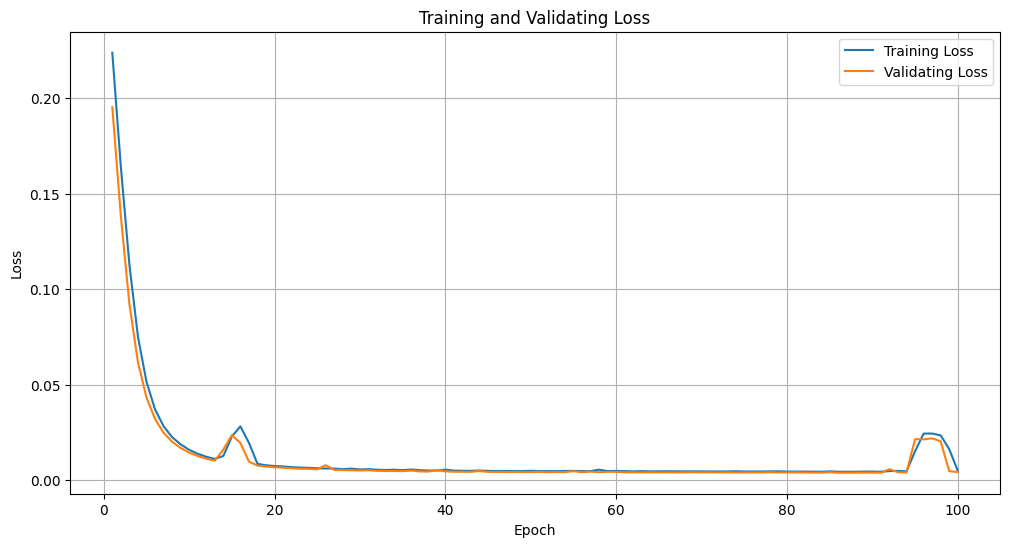

In [15]:
plot_loss(train_loss, val_loss, p.epochs, p.lr, train_time, p.E_layer, p.d_model)

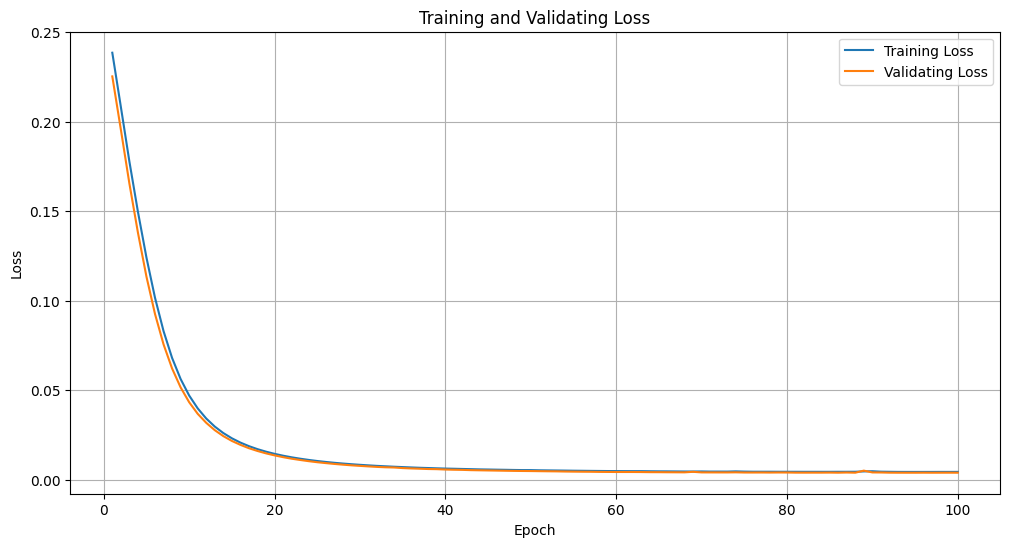

In [67]:
%run tf_helpers.py 
%run tf_attention.py

#  batch_size = 4
# gradient_accumulation_steps = 4
# device = 'gpu'
# input_dim = 7
# output_dim = 3
# d_model = 512
# heads = 8
# E_layer = 8 
# D_layer = 1 
# epochs = 100
# lr = 0.001
# dropout = 0.5 # for dense layer
# mha_dropout = 0.1 # multihead attention dropout
# l2_reg = 1e-4 # for kernel_regularizer
# loss_fn = MeanSquaredError()
# Val loss: 0.004
plot_loss(train_loss, val_loss, p.epochs, p.lr, train_time, p.E_layer, p.d_model)

MSE: 47328.6562, RMSE: 217.5515, MAE: 47.9207


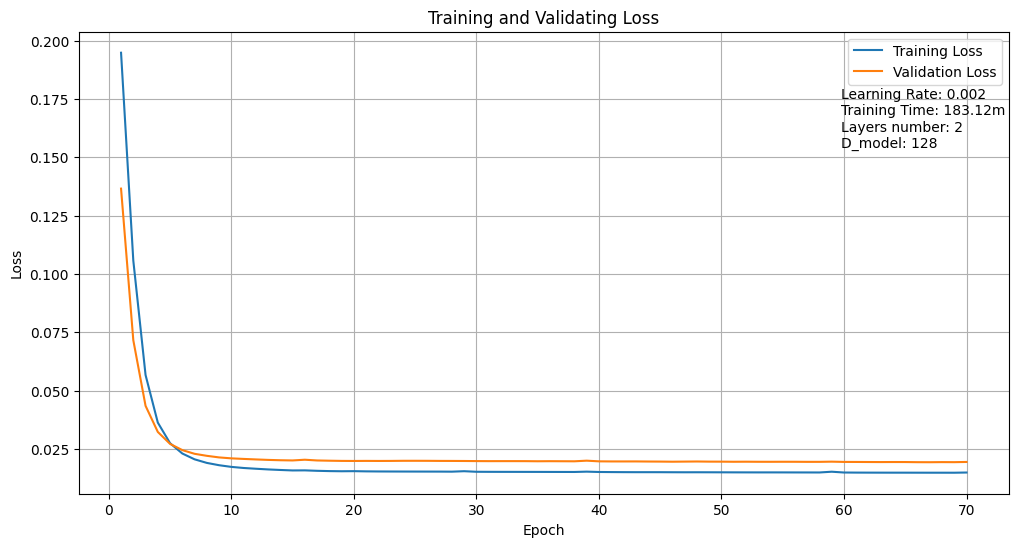

In [47]:
# Apply scaler, 8 heads
#  batch_size = 8, datasize = 7000, dropout 0.5
mse, rmse, mae, mape = evaluate_model(trained_model, test_data_loader, scalers, param.device)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

plot_loss(train_loss, val_loss, param.epochs, param.lr, train_time, param.N, param.d_model)

Test RMSE: 0.0932, Test MAE: 0.0132, Test MAPE: 177268.4062


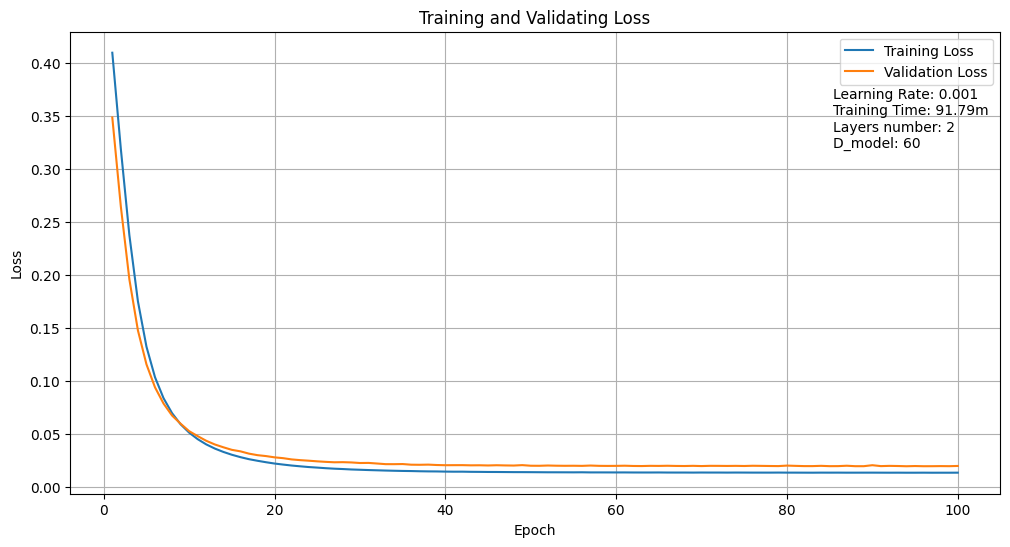

In [31]:
%run tf_attention.py
%run Parameters.py
param = Params()

# 6 heads
rmse, mae, mape = evaluate_model(model, test_data_loader, param.device)
print(f"Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}, Test MAPE: {mape:.4f}")
plot_loss(train_loss, val_loss, param.epochs, param.lr, train_time, param.N, param.d_model)

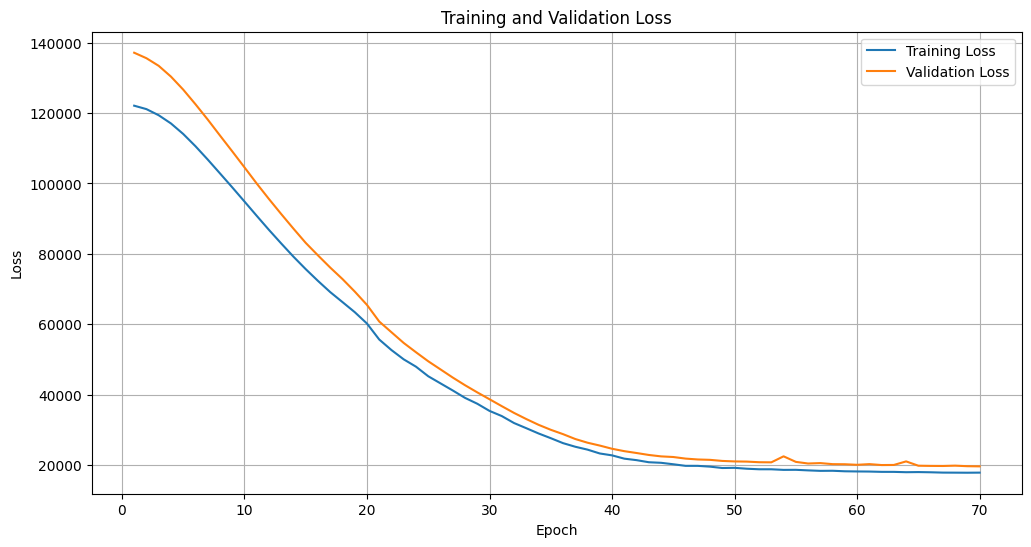

In [21]:
# 1st try, 70 epochs, lr 0.002, d-model 128, N 2
plot_loss(train_loss, val_loss, epochs)